# Ejemplo Series de Tiempo

In [875]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error



## La Serie

Vamos a trabajar con la serie de tiempo AirPassenger. Los datos describen la cantidad total de pasajeros de una aerolínea por mes entre los años 1949 a 1960. Se presentan las primeras 6 filas del conjunto de datos:

In [876]:
tf.random.set_seed(123)
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
airPas = pd.read_csv('../data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print ('\n Parsed Data:')
airPas.head()


 Parsed Data:


C:\Users\FLAQUI~1\AppData\Local\Temp/ipykernel_34992/3837750487.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


A continuación podemos ver el gráfico de la serie. 

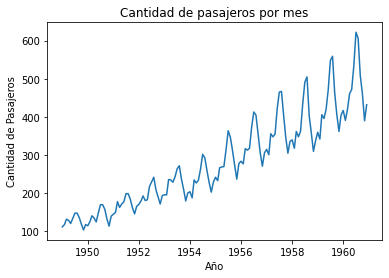

In [877]:
plt.plot(airPas)
plt.gca().set(title="Cantidad de pasajeros por mes", xlabel="Año", ylabel="Cantidad de Pasajeros")
plt.show()

Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media

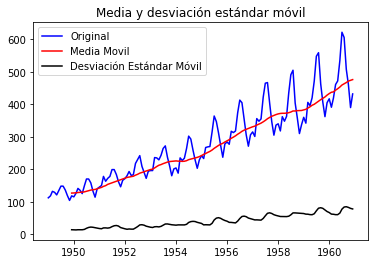

In [878]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = airPas.rolling(window=12).mean()
deMovil = airPas.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(airPas, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

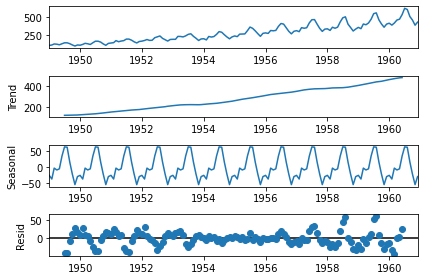

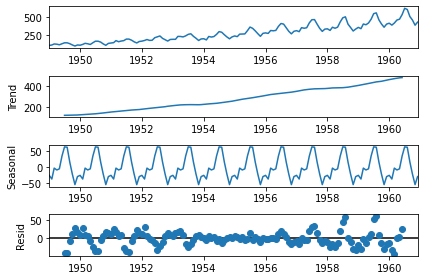

In [879]:
descomposicion = seasonal_decompose(airPas)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [880]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(airPas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.815369
p-value                        0.991880
# de retardos usados          13.000000
# de observaciones usadas    130.000000
Critical Value (1%)           -3.481682
Critical Value (5%)           -2.884042
Critical Value (10%)          -2.578770
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [881]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = airPas.diff()
ts_air_pas_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -2.889186
p-value                        0.046620
# de retardos usados          12.000000
# de observaciones usadas    131.000000
Critical Value (1%)           -3.481282
Critical Value (5%)           -2.883868
Critical Value (10%)          -2.578677
dtype: float64


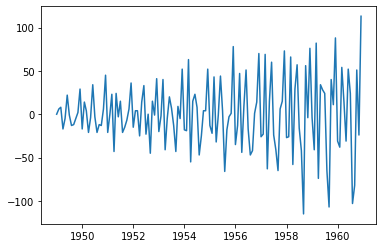

In [883]:
plt.plot(ts_air_pas_diff)

Las redes neuronales trabajan mejor con los datos normalizados así que vamos a normalizar la serie:

In [884]:
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(ts_air_pas_diff) 
ts_air_pas_scaled[1:7]


array([[ 0.14473016],
       [ 0.19543854],
       [-0.43841619],
       [-0.13416592],
       [ 0.55039719],
       [-0.03274916]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [885]:
entrenamiento = round(0.6*len(ts_air_pas_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

30

Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [886]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)




## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote, también conocido como tamaño del lote.
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Vamos a convertir los conjuntos en matrices de 3 dimensiones:

In [887]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

29

### Creamos el modelo.   
Vamos a utilizar solo una capa lstm  

In [888]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (1, 1)                    12        
                                                                 
 dense_14 (Dense)            (1, 1)                    2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 

In [889]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Vamos a entrenar el modelo. Para eso configuramos las épocas que es la cantidad de iteraciones. Lo pondremos en 50.

In [890]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
86/86 [==============================] - 2s 6ms/step - loss: 0.4498 - val_loss: 1.2204
Epoch 2/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4489 - val_loss: 1.2190
Epoch 3/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4481 - val_loss: 1.2174
Epoch 4/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4471 - val_loss: 1.2156
Epoch 5/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4461 - val_loss: 1.2136
Epoch 6/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4449 - val_loss: 1.2113
Epoch 7/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4436 - val_loss: 1.2087
Epoch 8/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4421 - val_loss: 1.2059
Epoch 9/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4406 - val_loss: 1.2028
Epoch 10/50
86/86 [==============================] - 0s 2ms/step - loss: 0.4389 - val_loss: 1.1993
Epoch 11/50
86/86 [

Como vemos la pérdida empieza a disminuir bastante bien hasta la época 40 que parece estancarse. Hay bastante diferencia entre el modelo de entrenamiento y el de validación.  

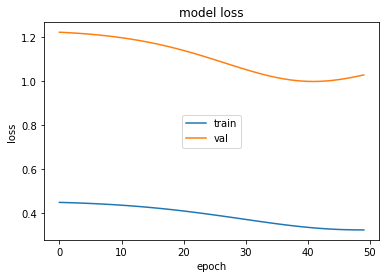

In [891]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [892]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
3/3 [==============================] - 0s 2ms/step - loss: 0.5015
Pérdida en Validación
1/1 [==============================] - 0s 20ms/step - loss: 1.2955
Pérdida en Prueba
1/1 [==============================] - 0s 20ms/step - loss: 2.4060


2.4060158729553223

Ahora vamos a predecir con el modelo 1.  

In [896]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = NULL , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = airPas.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = airPas.values , n=entrenamiento+val_prueba)


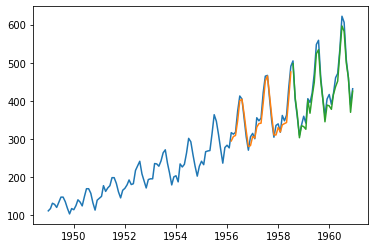

In [894]:
df_val = pd.DataFrame(prediccion_val,index=airPas[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=airPas[entrenamiento+len(df_val):len(airPas)].index)


plt.plot(airPas)
plt.plot(df_val)
plt.plot(df_test)

